In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
#import radical.entk as re

In [2]:
!radical-stack


  python               : 3.6.13
  pythonpath           : 
  virtualenv           : ra

  radical.analytics    : 1.5.0
  radical.gtod         : 1.5.0
  radical.pilot        : 1.5.1
  radical.saga         : 1.6.6
  radical.utils        : 1.5.1



In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
import glob

sids = glob.glob('mdff-exp/*')

sids = ['re.session.login2.hrlee.018724.0004',
        're.session.login5.hrlee.018743.0000',
        're.session.login2.hrlee.018725.0001'
       ]
sids = [ "mdff-exp/{}".format(x) for x in sids ]
sessions = []
suds = []
for sid in sids:
    print(sid)
    session = ra.Session(sid, "radical.pilot")
    sessions.append(session)
    suds.append(session.uid)

mdff-exp/re.session.login2.hrlee.018724.0004
mdff-exp/re.session.login5.hrlee.018743.0000
mdff-exp/re.session.login2.hrlee.018725.0001


In [5]:
ss = {}
for session in sessions:
    sid = session.uid
    ss[sid] = {'s': session}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [6]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'expid'   : sid,                    
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [7]:
ss[sid]['p'].get(uid=ss[sid]['pid'][0])[0].description

{'access_schema': 'local',
 'app_comm': [],
 'candidate_hosts': [],
 'cleanup': False,
 'cores': 5376,
 'exit_on_error': True,
 'gpus': 0,
 'input_staging': ['pdb/4ake-target.pdb',
  'pdb/1ake-docked-noh.pdb',
  'pdb/target-density-5A.dx'],
 'job_name': None,
 'layout': 'default',
 'memory': 0,
 'output_staging': None,
 'project': 'BIP212',
 'queue': 'killable',
 'resource': 'ornl.summit',
 'runtime': 239,
 'sandbox': None}

In [8]:
info = []
for sid in suds:
    info.append({'session'  : sid,
                 'exp_id'   : sid,
                 'resource' : ss[sid]['pres'],
                 'pilot_lm' : ss[sid]['lm'], 
                 'pilots'   : ss[sid]['npilot'],
                 'ps_active': ss[sid]['npact'],
                 'cores'    : ss[sid]['ncores']/4, 
                 'gpus'     : ss[sid]['ngpus'], 
                 'nodes'    : ss[sid]['nnodes'], 
                 'tasks'    : ss[sid]['nunit'], 
                 'ts_done'  : ss[sid]['nudone'],  
                 'ts_failed': ss[sid]['nufail']})

df_info = pd.DataFrame(info)

In [9]:
u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in rp.utils.UNIT_DURATIONS_DEBUG.items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

AttributeError: module 'radical.pilot.utils' has no attribute 'UNIT_DURATIONS_DEBUG'

In [105]:
p_durations = {}

for sid in suds:
    p_durations[sid] = {}

for sid in suds:
    for pid in ss[sid]['p'].list('uid'):
        pilot = ss[sid]['p'].get(etype='pilot', uid=pid)[0]
        durations = {}
        for k,v in rp.utils.PILOT_DURATIONS_DEBUG.items():
            try:
                durations[k] = pilot.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, pid, v))
                durations[k] = 0
        p_durations[sid].update({pid: durations})

In [10]:
for sid in suds:
    w  = ss[sid]['w']
    u  = ss[sid]['u']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'bootstrap_0_start', ru.STATE: None   },
                                 # {ru.EVENT: 'bootstrap_0_stop', ru.STATE: None    }]),
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE    },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED  },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED}]]),
      'ttx_u': u.duration( event=[ {ru.EVENT: 'cu_exec_start', ru.STATE: None       },      
                                   {ru.EVENT: 'cu_exec_stop' , ru.STATE: None       } ])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_p'] - ss[sid]['ttx_u']})

In [11]:
ovh_rtc = {}
ttx_u = {}
for sid in ss:
    expid = ss[sid]['expid']
    if expid not in ovh_rtc.keys():
        ovh_rtc[expid] = []
        ttx_u[expid] = []
    ovh_rtc[expid].append(ss[sid]['ovh_rtc'])
    ttx_u[expid].append(ss[sid]['ttx_u'])
#     if expid == 'PLC-4':
#         display("%s: %s" % (sid,ss[sid]['ttx_u']))

pcl_overheads = []
for expid in ovh_rtc.keys():
    pcl_overheads.append({'Exp. ID' : expid, 
                          'TTX': np.mean(ttx_u[expid]),
                          'OVH': np.mean(ovh_rtc[expid])})

df_pcl_overheads = pd.DataFrame(pcl_overheads) 
df_pcl_overheads

,Exp. ID,TTX,OVH
0,re.session.login2.hrlee.018724.0004,3783.0,335.265615
1,re.session.login5.hrlee.018743.0000,2497.0,273.065739
2,re.session.login2.hrlee.018725.0001,1882.0,174.903531


In [13]:
for sid in suds:
    print("""
%s:
\tName of the HPC platform: %s
\tPilot launch method: %s
\tNumber of pilots requested: %i
\tNumber of pilots active: %i
\tNumber of requested cores: %i
\tNumber of requested GPUs: %s
\tNumber of requested nodes: %s
\tNumber of nodes asked by ENTK: %i
\tNumber of tasks executed by EnTK: %i
\tNumber of tasks successfully executed by EnTK: %i
\tNumber of failed tasks: %i
""" % (sid              , ss[sid]['pres']  , ss[sid]['lm'], 
       ss[sid]['npilot'], ss[sid]['npact'] , ss[sid]['ncores']/4, 
       ss[sid]['ngpus'] , ss[sid]['nnodes'], ss[sid]['ncores']/168, 
       ss[sid]['nunit'] , ss[sid]['nudone'], ss[sid]['nufail']))


re.session.login2.hrlee.018724.0004:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 336
	Number of requested GPUs: 0
	Number of requested nodes: 0.0
	Number of nodes asked by ENTK: 8
	Number of tasks executed by EnTK: 1024
	Number of tasks successfully executed by EnTK: 1024
	Number of failed tasks: 0


re.session.login5.hrlee.018743.0000:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 672
	Number of requested GPUs: 0
	Number of requested nodes: 0.0
	Number of nodes asked by ENTK: 16
	Number of tasks executed by EnTK: 2048
	Number of tasks successfully executed by EnTK: 2048
	Number of failed tasks: 0


re.session.login2.hrlee.018725.0001:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of 

In [14]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [15]:
sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

In [16]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [17]:
def update_ticks(x, pos):
    return int(x/168)

/home/hrlee/miniconda3/envs/ra/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


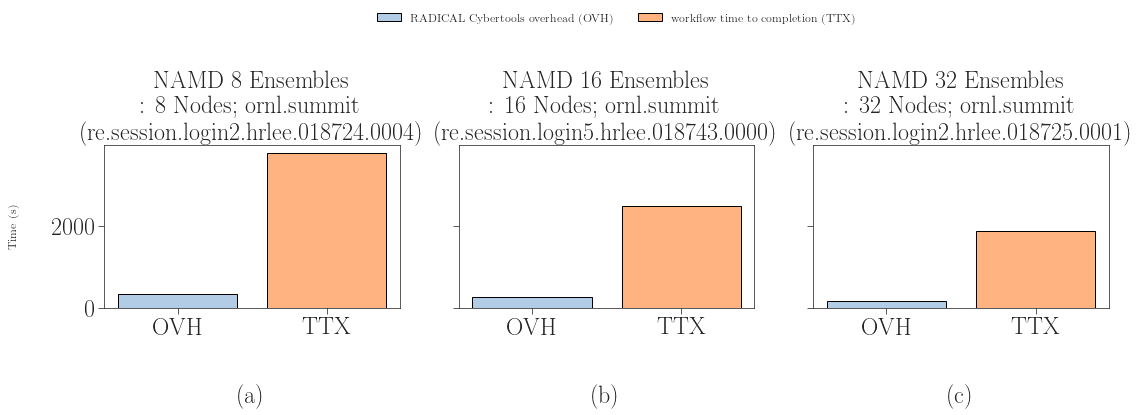

In [18]:
fwidth = 6*len(ovh_rtc.keys())
fheight = 3
fig, axarr = plt.subplots(1, len(ovh_rtc.keys()), sharey=True, figsize=(fwidth, fheight))

i = 0
j = 'a'
for expid in ovh_rtc.keys():
    if len(ovh_rtc.keys()) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('NAMD %s Ensembles\n: %s Nodes; %s\n(%s)' % (
        int(df_info[df_info['exp_id'] == expid]['cores']) // 42, 
        int(df_info[df_info['exp_id'] == expid]['cores']) // 42,
        df_info[df_info['exp_id'] == expid]['resource'].tolist()[0],
        expid))

    ax.bar(x = 'OVH', 
           height = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['OVH'], 
           color = tableau20[1])
    ax.bar(x = 'TTX', 
           height = df_pcl_overheads[df_pcl_overheads['Exp. ID'] == expid]['TTX'], 
           color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=45)
    #ax.set_yscale('log')

    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.05,  0.5 , 'Time (s)', va='center', rotation='vertical', fontsize=12)
#fig.text( 0.5 , -0.05, 'Metric'  , ha='center', fontsize=12)
fig.legend(['RADICAL Cybertools overhead (OVH)', 'workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.52, 1.55), fontsize=12, ncol=2)

plt.tight_layout()
plt.savefig('gordonbell_namd_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('gordonbell_namd_ovh_ttx.png', dpi=300, bbox_inches='tight')

In [19]:
ovh_rtc

{'re.session.login2.hrlee.018724.0004': [335.2656145095825],
 're.session.login5.hrlee.018743.0000': [273.06573939323425],
 're.session.login2.hrlee.018725.0001': [174.9035313129425]}

In [20]:
df_pcl_overheads

,Exp. ID,TTX,OVH
0,re.session.login2.hrlee.018724.0004,3783.0,335.265615
1,re.session.login5.hrlee.018743.0000,2497.0,273.065739
2,re.session.login2.hrlee.018725.0001,1882.0,174.903531


In [122]:
df_info

,session,exp_id,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed
0,re.session.login2.hrlee.018724.0004,re.session.login2.hrlee.018724.0004,ornl.summit,JSRUN,1,1,336.0,0,0.0,1024,1024,0
1,re.session.login5.hrlee.018743.0000,re.session.login5.hrlee.018743.0000,ornl.summit,JSRUN,1,1,672.0,0,0.0,2048,2048,0
2,re.session.login2.hrlee.018725.0001,re.session.login2.hrlee.018725.0001,ornl.summit,JSRUN,1,1,1344.0,0,0.0,4096,4096,0


In [123]:
ovh_rtc

{'re.session.login2.hrlee.018724.0004': [335.2656145095825],
 're.session.login5.hrlee.018743.0000': [273.06573939323425],
 're.session.login2.hrlee.018725.0001': [174.9035313129425]}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


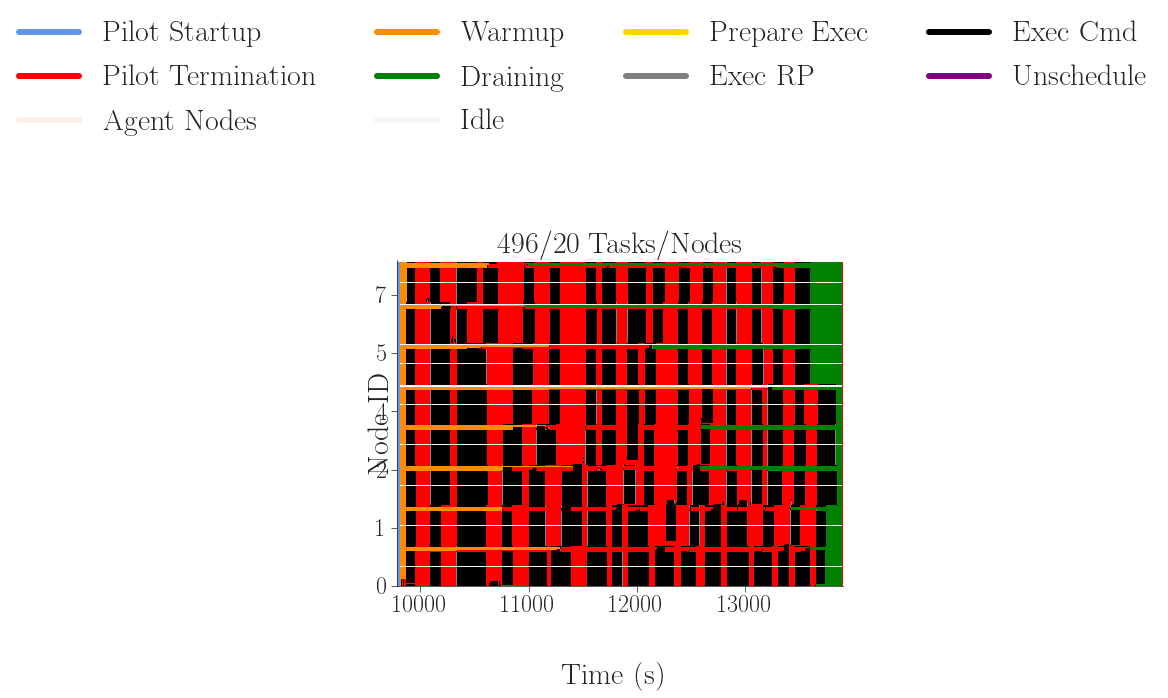

In [21]:
# core/gpu utilization over time (box plot)
import matplotlib.colors as mcolors

fig, ax  = fig_setup(figsize=(8,6))

cmap = mpl.cm.get_cmap('tab20c')

step = 1.0 / (len(metrics_default) + 1)
this = step / 1.0
legend = list()

x_min = None
x_max = None
y_min = None
y_max = None

#wsid = 're.session.login1.hrlee.018425.0026'

sid = 're.session.login2.hrlee.018724.0004'
ax.set_title('496/20 Tasks/Nodes', fontdict={'fontsize': 30})

colors = {0: mcolors.CSS4_COLORS['cornflowerblue'], # pilot startup
          1: mcolors.CSS4_COLORS['red'],            # pilot termination
          2: mcolors.CSS4_COLORS['linen'],         # agent nodes
          3: mcolors.CSS4_COLORS['darkorange'],         # warmup
          4: mcolors.CSS4_COLORS['green'],          # Draining
          5: mcolors.CSS4_COLORS['whitesmoke'],          # idle
          6: mcolors.CSS4_COLORS['gold'],         # prepare exec
          7: mcolors.CSS4_COLORS['gray'],           # exec rp
          8: mcolors.CSS4_COLORS['black'],          # exec cmd
          9: mcolors.CSS4_COLORS['purple']}          # unschedule

ccounter = 0
for metric in metrics_default:

    color = colors[ccounter]# cmap(this)
    this += step

    legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

    if isinstance(metric, list):
        name = metric[0]
        parts = metric[1]
    else:
        name = metric
        parts = [metric]

    for part in parts:
        for uid in consumed[sid][part]:
            for block in consumed[sid][part][uid]:
                orig_x = block[0]
                orig_y = block[2] - 0.5
                width = block[1] - block[0]
                height = block[3] - block[2] + 1.0

                if x_min is None:
                    x_min = orig_x
                if x_max is None:
                    x_max = orig_x + width
                if y_min is None:
                    y_min = orig_x
                if y_max is None:
                    y_max = orig_x + height

                x_min = min(x_min, orig_x)
                y_min = min(y_min, orig_y)
                x_max = max(x_max, orig_x + width)
                y_max = max(y_max, orig_y + height)

                patch = mpl.patches.Rectangle((orig_x, orig_y),
                                              width, height,
                                              facecolor=color,
                                              edgecolor='black',
                                              fill=True, lw=0.0)
                ax.add_patch(patch)
    
    ccounter += 1

# The session did not close cleanly. EnTK waited for ~800 seconds before deciding 
# that the pilot had died. After that, it closed the sesison and exited. This is 
# a degenerate run and, as such, not representative of the actual overheads on 
# properly terminated sessions. We then normalize the plot to account for such a
# condition. The analysis can be replicated by looking at the profile files in 
# the data/raw directory of this repository.
ax.set_xlim([x_min, x_max])
#ax.set_xlim([x_min, 7000])
ax.set_ylim([y_min, y_max])

ax.set_ylim([y_min, 1400])

# ax.set_xlabel('(%s)' % j, labelpad=45)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))


# Add common axes lables
fig.text(0.075,  0.5, 'Node ID' , va='center', rotation='vertical', fontsize=30)
fig.text(0.5 , -0.1, 'Time (s)', ha='center', fontsize=30)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.45, 1.5), fontsize=30, ncol=4)

#plt.savefig('figures/incite2020_deepdrivemd.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('figures/incite2020_deepdrivemd.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.02, 'Time (s)')

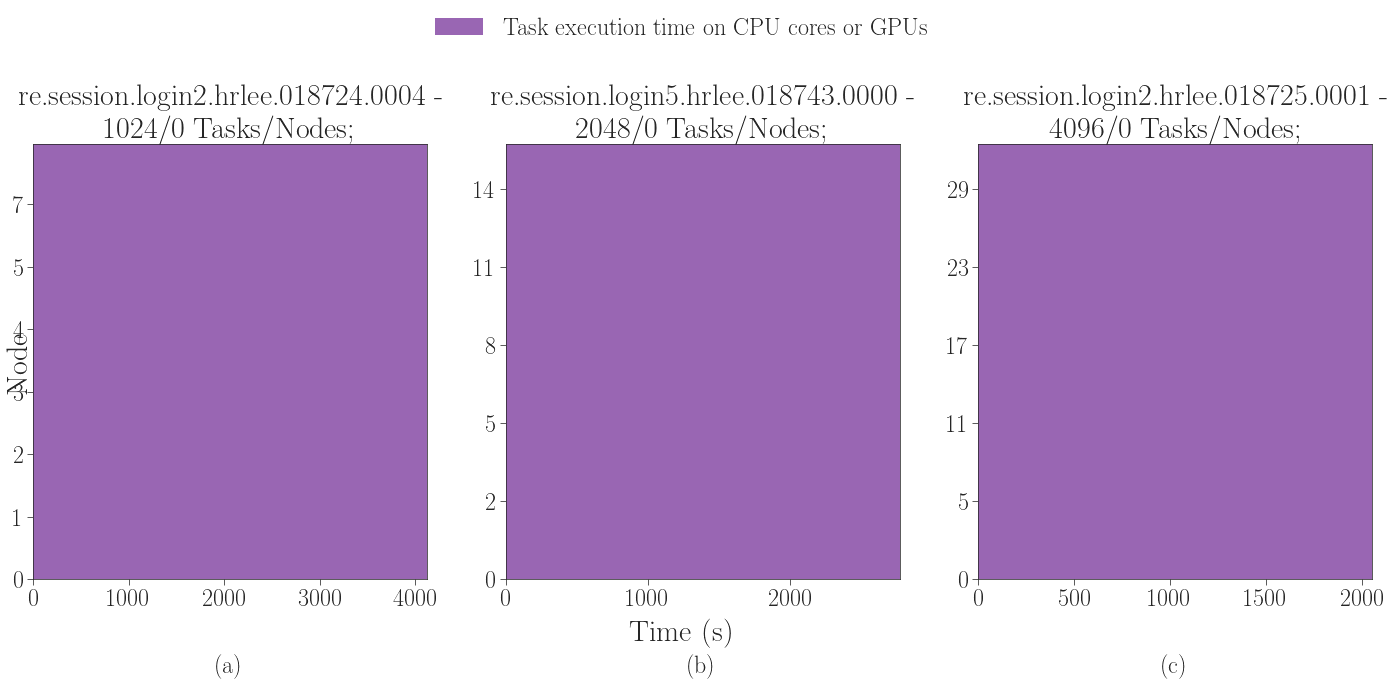

In [36]:
splot = ['re.session.login2.hrlee.018724.0004',
        're.session.login5.hrlee.018743.0000',
        're.session.login2.hrlee.018725.0001'
       ]

# zero points to zero the axes of the plot.
p_zeros = {}
for session in sobjs.sessions:
    for pilot in session.get(etype='pilot'):
        p_zeros[session.uid] = pilot.timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]
        
nsids = len(splot)-1

fwidth = 12*nsids
fhight = 8
fig, axarr = plt.subplots(1, nsids+1, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in splot:
    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    '''
    if '_' in df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0]:
        launcher = df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0].replace('_', '-')
    else:
        launcher = df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0]
    '''
    ax.set_title(
        #'%s - %s\n%s/%s Tasks/Nodes; %s Ligands.' % ( # %s Lig. Struct
        '%s - %s\n%s/%s Tasks/Nodes; %s' % ( # %s Lig. Struct
        ss[sid]['expid'],
            '',#launcher,
            ss[sid]['nunit'], 
            int(ss[sid]['nnodes']),
            '',#df_exp_design[df_exp_design['exp_id'] == ss[sid]['expid']]['lig'].tolist()[0],
            # df_exp_design[df_exp_design['exp_id'] == ss[sid]['expid']]['ligstruct'].tolist()[0]
        ), 
        fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = tableau20[8] #cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0] - p_zeros[sid]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    # ax.set_xlabel('Time (s)', fontsize=30)
    # ax.set_ylabel('Node', fontsize=30)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
# ax.legend(legend, [m[0] for m in metrics_default], loc='upper center', fontsize=30, ncol=4, bbox_to_anchor=( -0.5, 1.35))
fig.legend(['Task execution time on CPU cores or GPUs'], loc='upper center', bbox_to_anchor=(0.5, 1.14), fontsize=24, ncol=1)
fig.text( 0.11,  0.5 , 'Node'    , va='center', rotation='vertical', fontsize=30)
fig.text( 0.5,  0.02, 'Time (s)', ha='center', fontsize=30)

#plt.savefig('figures/paper_12122020_ru.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('figures/paper_12122020_ru.png', dpi=300, bbox_inches='tight')

In [27]:
ss

{'re.session.login2.hrlee.018724.0004': {'s': <radical.analytics.session.Session at 0x7f7195b28f98>,
  'p': <radical.analytics.session.Session at 0x7f7187eca240>,
  'u': <radical.analytics.session.Session at 0x7f717a28bbe0>,
  't': <radical.analytics.session.Session at 0x7f7176cce550>,
  'w': <radical.analytics.session.Session at 0x7f71736f4e80>,
  'sid': 're.session.login2.hrlee.018724.0004',
  'pid': ['pilot.0000'],
  'expid': 're.session.login2.hrlee.018724.0004',
  'npilot': 1,
  'lm': 'JSRUN',
  'npact': 1,
  'nunit': 1024,
  'nudone': 1024,
  'nufail': 0,
  'pres': 'ornl.summit',
  'ncores': 1344,
  'ngpus': 0,
  'nnodes': 0.0,
  'ttx_p': 4118.2656145095825,
  'ttx_u': 3783.0,
  'ovh_rtc': 335.2656145095825},
 're.session.login5.hrlee.018743.0000': {'s': <radical.analytics.session.Session at 0x7f71917d5da0>,
  'p': <radical.analytics.session.Session at 0x7f7170129a20>,
  'u': <radical.analytics.session.Session at 0x7f716b992b00>,
  't': <radical.analytics.session.Session at 0x7f7

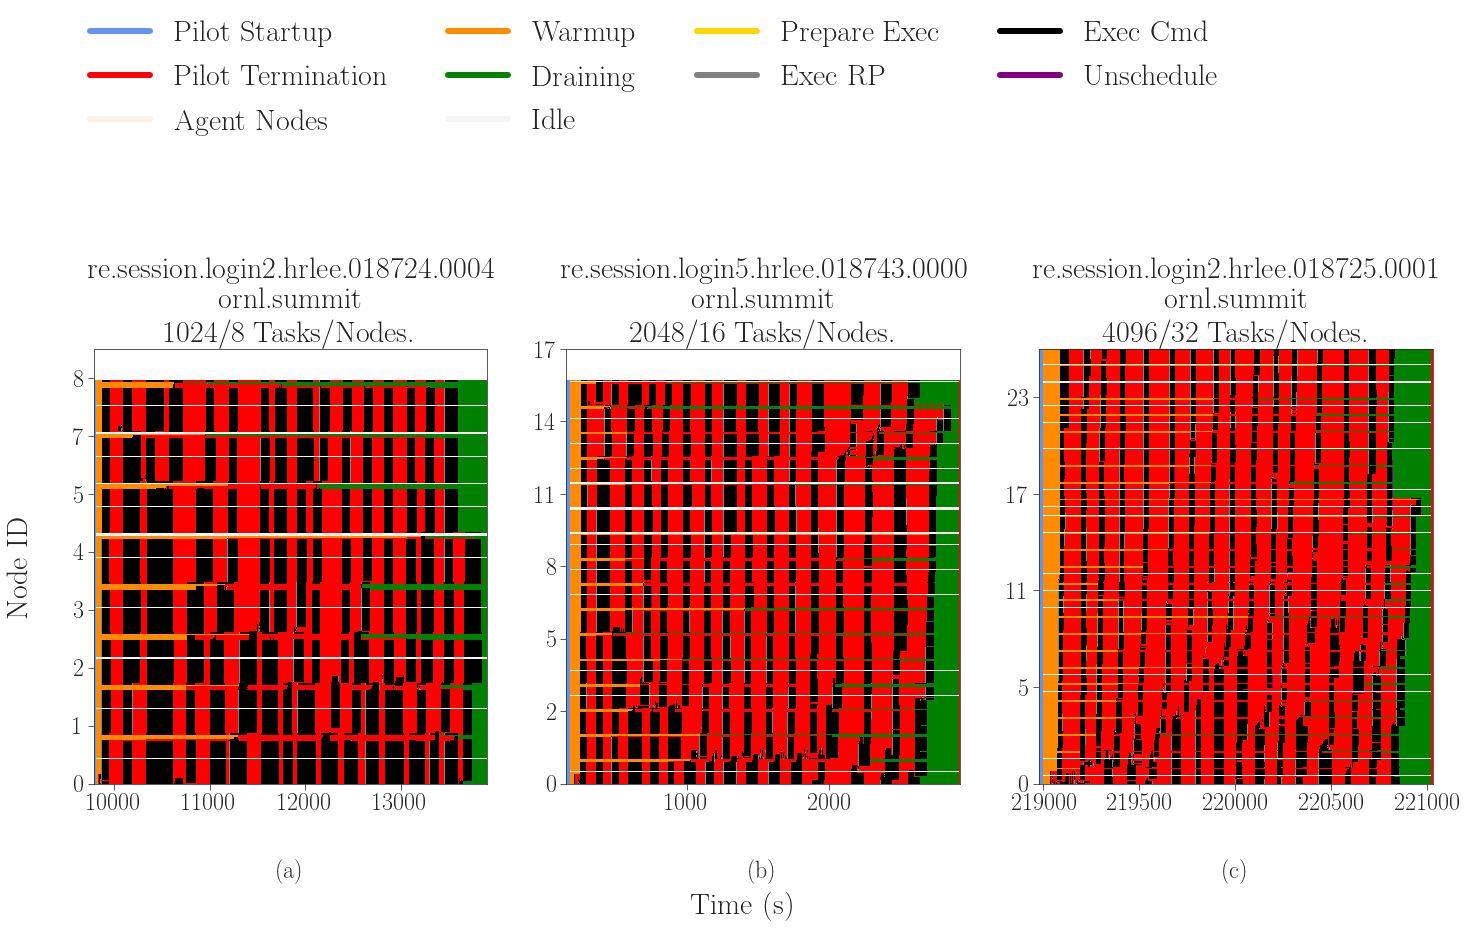

In [154]:
# core/gpu utilization over time (box plot)
import matplotlib.colors as mcolors
splot = [
        're.session.login3.hrlee.018766.0012',
    're.session.login4.hrlee.018766.0018',
    're.session.login4.hrlee.018766.0019'
]
splot = ['re.session.login2.hrlee.018724.0004',
 're.session.login5.hrlee.018743.0000',
 're.session.login2.hrlee.018725.0001']

#splot = ['re.session.login2.hrlee.018724.0004']
nsids = len(splot)-1

fwidth = 12*nsids
fhight = 8
fig, axarr = plt.subplots(1, nsids+1, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in splot:
    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    if '_' in df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0]:
        launcher = df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0].replace('_', '-')
    else:
        launcher = df_info[df_info['exp_id'] == ss[sid]['expid']]['resource'].tolist()[0]
    
    ax.set_title(
        '%s\n%s\n%s/%s Tasks/Nodes.' % ( # %s Lig. Struct
            ss[sid]['expid'],
            launcher,
            ss[sid]['nunit'], 
            int(ss[sid]['ncores']) // 168,
            #df_exp_design[df_exp_design['exp_id'] == ss[sid]['expid']]['lig'].tolist()[0],
            # df_exp_design[df_exp_design['exp_id'] == ss[sid]['expid']]['ligstruct'].tolist()[0]
        ), 
        fontdict={'fontsize': 30})
    


    colors = {0: mcolors.CSS4_COLORS['cornflowerblue'], # pilot startup
              1: mcolors.CSS4_COLORS['red'],            # pilot termination
              2: mcolors.CSS4_COLORS['linen'],         # agent nodes
              3: mcolors.CSS4_COLORS['darkorange'],         # warmup
              4: mcolors.CSS4_COLORS['green'],          # Draining
              5: mcolors.CSS4_COLORS['whitesmoke'],          # idle
              6: mcolors.CSS4_COLORS['gold'],         # prepare exec
              7: mcolors.CSS4_COLORS['gray'],           # exec rp
              8: mcolors.CSS4_COLORS['black'],          # exec cmd
              9: mcolors.CSS4_COLORS['purple']}          # unschedule

    ccounter = 0
    for metric in metrics_default:

        color = colors[ccounter]# cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

        ccounter += 1

    # The session did not close cleanly. EnTK waited for ~800 seconds before deciding 
    # that the pilot had died. After that, it closed the sesison and exited. This is 
    # a degenerate run and, as such, not representative of the actual overheads on 
    # properly terminated sessions. We then normalize the plot to account for such a
    # condition. The analysis can be replicated by looking at the profile files in 
    # the data/raw directory of this repository.
    ax.set_xlim([x_min, x_max])
    #ax.set_xlim([x_min, 7000])
    ax.set_ylim([y_min, y_max])
    ax.set_ylim([y_min, 1500 * (i + 1)])
    #print(y_max)

    # ax.set_x label('(%s)' % j, labelpad=45)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add common axes lables
fig.text(0.075,  0.5, 'Node ID' , va='center', rotation='vertical', fontsize=30)
fig.text(0.5 , -0.1, 'Time (s)', ha='center', fontsize=30)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.45, 1.5), fontsize=30, ncol=4)

#plt.savefig('figures/incite2020_deepdrivemd.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('figures/incite2020_deepdrivemd.png', dpi=300, bbox_inches='tight')